In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch

from time import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('../data/170.csv', sep=";", header=None)

df[10:].to_csv("../data/upd170.csv", 
                    header=None, 
                    index=None)

df = pd.read_csv("../data/upd170.csv", decimal=',')

data = df.loc[:, ['DEPTH', 'RESISTIVITY', 'GAMMA RAY',
       'DENSITY LOG', 'SONIC LOG P-WAVE', 'SONIC LOG S- WAVE', 'SONIC LOG',
       'CALIPER', 'NEUTRON LOG', 'TOTAL POROSITY ']]

for i, column in enumerate(['RESISTIVITY', 'GAMMA RAY',
       'DENSITY LOG', 'SONIC LOG P-WAVE', 'SONIC LOG S- WAVE', 'SONIC LOG',
       'CALIPER', 'NEUTRON LOG']):
  data[column].fillna(value=None, method='ffill', 
                      axis=None, downcast=None,
                      inplace=True)

In [3]:
def update_features_data(data, features):
    window_mean = {column: [] for column in features}
    window_std = {column: [] for column in features}
    window_lag = {column: [] for column in features}
    window_diff = {column: [] for column in features}

    buffer_1m = []

    for index, row in data.iterrows():
        cur_depth = row['DEPTH']
        i=0
        for i, buf_row in enumerate(buffer_1m):
          if cur_depth - 1. <= buf_row['DEPTH']:
            break
        buffer_1m = buffer_1m[i:]
        buffer_1m.append(row)

        #transforming given features

        for column in features:
          window_mean[column].append(np.mean([r[column] for r in buffer_1m]))
          window_std[column].append(np.std([r[column] for r in buffer_1m]))
          window_lag[column].append(buffer_1m[-1][column] if len(buffer_1m) else np.nan)
          window_diff[column].append(buffer_1m[-1][column] - buffer_1m[0][column] if len(buffer_1m) else np.nan)    

    for column in features:
      data["window_mean "+column] = window_mean[column]
      data["window_std "+column] = window_std[column]
      data["window_lag "+column] = window_lag[column]
      data["window_dif "+column] = window_diff[column]

In [4]:
update_features_data(data, features=['DENSITY LOG', 'NEUTRON LOG'])

test_data = data.iloc[-2000:]

X = data.drop(columns=["TOTAL POROSITY ", "DEPTH"]).iloc[20:-2000].values
y = data.iloc[20:-2000]["TOTAL POROSITY "].values

X_test = test_data.drop(columns=["TOTAL POROSITY ", "DEPTH"]).values
y_test = test_data["TOTAL POROSITY "].values

In [5]:
scaler = StandardScaler()

normed_X = scaler.fit_transform(X)

normed_X_test = scaler.transform(X_test)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

Creating sequential dataset

In [6]:
raw_length = 100

In [7]:
#train
seq_X = []

for i in range(raw_length, len(normed_X)):
    seq_X.append(normed_X[i-raw_length:i])

X_train = np.array(seq_X)
y_train = y[raw_length:][:, np.newaxis]



#test without first raw_length sequentials
seq_X = []

for i in range(raw_length, len(normed_X_test)):
    seq_X.append(normed_X_test[i-raw_length:i])



X_test = np.array(seq_X)
y_test = y_test[raw_length:][:, np.newaxis]

In [10]:
class LSTM_like(nn.Module):
    def __init__(self, inp_size=8, lstm_size=200, num_layers=3):
        super(self.__class__, self).__init__()
        self.lstm_size = lstm_size
        self.inp_size = inp_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=self.inp_size, 
                             hidden_size=self.lstm_size,
                             num_layers=self.num_layers,
                             dropout=0.2)
        
        self.hid = nn.Linear(self.lstm_size, 1)
        
    def forward(self, x, prev_state):
        feat, _ = self.lstm(torch.transpose(x, 0, 1), prev_state)

        out = self.hid(feat[-1])

        return out

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [11]:
def iterate_minibatches(X, y, batchsize, shuffle=True):
    indices = np.arange(len(X))
    if shuffle:
        indices = np.random.permutation(indices)
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [12]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch).to(device)
    y_batch = torch.FloatTensor(y_batch).to(device)

    state_h, state_c = model.init_state(X_batch.shape[0])

    logits = model.to(device)(X_batch, (state_h.to(device), state_c.to(device)))
    return F.mse_loss(logits, y_batch).mean()

In [13]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

model = LSTM_like(inp_size=16, lstm_size=30, num_layers=1).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

train_loss = []
val_loss = []

num_epochs = 10 # общее кол-во полных проходов по обучаемым данным
batch_size = 100  # кол-во объектов в одном батче

for epoch in range(num_epochs):
    # На каждой эпохе делаем полный проход по данным
    start_time = time()
    model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение
    for i, (X_batch, y_batch) in enumerate(iterate_minibatches(X_train, y_train, batch_size)):
        # Обучаемся на батче
        loss = compute_loss(X_train, y_train)
        # print("compute", i)
        loss.backward()      # обратный проход, считаем градиенты
        opt.step()           # делаем шаг градиентного спуска
        opt.zero_grad()      # зануляем градиенты        
        # print("after grad")
        train_loss.append(float(loss))
        
    # Полный проход по валидации
    model.train(False) # устанавливаем поведение dropout / batch_norm  в тестирование
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
        state_h, state_c = model.init_state(X_batch.shape[0])
        out = model(torch.FloatTensor(X_batch).to(device), 
                    (state_h.to(device), state_c.to(device))).cpu().data.numpy()
        val_loss.append(np.mean((y_batch - out)**2))
    
    # Печатаем результаты после каждой эпохи
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-len(X_test) // batch_size :])))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1 of 10 took 4.828s
  training loss (in-iteration): 	0.003849
  validation loss: 			0.000218
Epoch 2 of 10 took 4.574s
  training loss (in-iteration): 	0.000096
  validation loss: 			0.000154
Epoch 3 of 10 took 4.573s
  training loss (in-iteration): 	0.000062
  validation loss: 			0.000133
Epoch 4 of 10 took 4.571s
  training loss (in-iteration): 	0.000050
  validation loss: 			0.000124
Epoch 5 of 10 took 4.588s
  training loss (in-iteration): 	0.000043
  validation loss: 			0.000118
Epoch 6 of 10 took 4.586s
  training loss (in-iteration): 	0.000039
  validation loss: 			0.000113
Epoch 7 of 10 took 4.583s
  training loss (in-iteration): 	0.000035
  validation loss: 			0.000108
Epoch 8 of 10 took 4.568s
  training loss (in-iteration): 	0.000032
  validation loss: 			0.000104
Epoch 9 of 10 took 4.586s
  training loss (in-iteration): 	0.000030
  validation loss: 			0.000100
Epoch 10 of 10 took 4.567s
  training loss (in-iteration): 	0.000028
  validation loss: 			0.000098


In [8]:
#169

df169 = pd.read_csv('../data/169.csv', sep=";", header=None)

df169[10:].to_csv("../data/upd 169.csv", header=None, index=None)

df169 = pd.read_csv("../data/upd 169.csv", decimal=',')

df169 = df169.loc[:, ['DEPTH', 'RESISTIVITY', 'GAMMA RAY',
      'DENSITY LOG', 'SONIC LOG P-WAVE', 'SONIC LOG S- WAVE', 'SONIC LOG',
      'CALIPER', 'NEUTRON LOG', 'TOTAL POROSITY ']]

df169.replace(-9999, np.NaN, inplace=True)

for i, column in enumerate(['RESISTIVITY', 'GAMMA RAY',
      'DENSITY LOG', 'SONIC LOG P-WAVE', 'SONIC LOG S- WAVE', 'SONIC LOG',
      'CALIPER', 'NEUTRON LOG']):
  df169[column].fillna(value=None, method='ffill', 
                      axis=None, downcast=None,
                      inplace=True)

update_features_data(df169, features=['DENSITY LOG', 'NEUTRON LOG'])

df169.fillna(-9999, inplace=True)

X_169 = df169.drop(columns=["TOTAL POROSITY ", "DEPTH"]).values
y_169 = df169["TOTAL POROSITY "].values

normed_X_169 = scaler.transform(X_169)


In [9]:
#test without first raw_length sequentials
seq_X = []

for i in range(raw_length, len(normed_X_169)):
    seq_X.append(normed_X_169[i-raw_length:i])

X_169 = np.array(seq_X)
y_169 = y_169[raw_length:][:, np.newaxis]

In [16]:
for X_well, y_well, name in zip([X_test, X_169],
                                [y_test, y_169],
                                ["170", "169"]):

    state_h, state_c = model.init_state(X_well.shape[0])
    y_pred = model(torch.FloatTensor(X_well).to(device), 
                    (state_h.to(device), state_c.to(device))).cpu().data.numpy()
    print(name, ":")

    print("RMSE", mean_squared_error(y_well, y_pred, squared = False))
    print("MAE", mean_absolute_error(y_well, y_pred))
    print("R^2", r2_score(y_well, y_pred))
    print("----------------------")

170 :
RMSE 0.009879933170037538
MAE 0.006630441987285488
R^2 0.9372177338005585
----------------------
169 :
RMSE 0.2004408177063567
MAE 0.18924831844082918
R^2 -22.544238128844594
----------------------


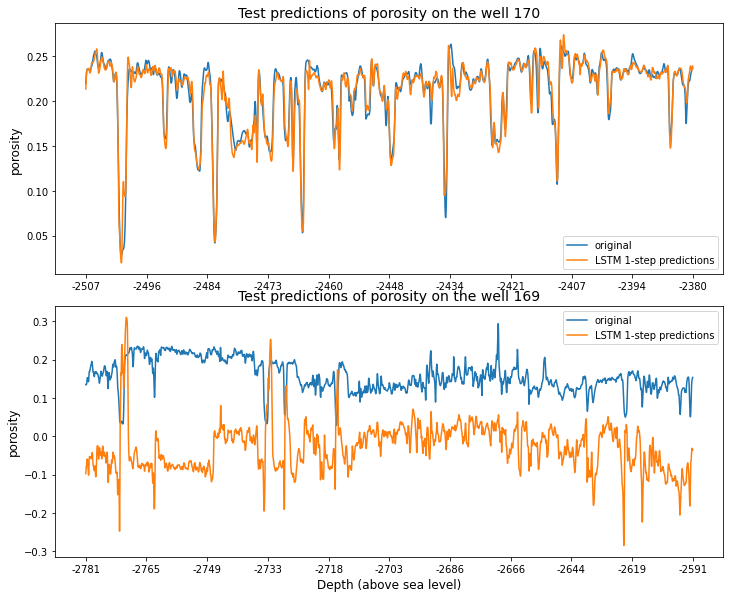

In [17]:
f, axes = plt.subplots(2, 1, figsize=(10, 8))

f.tight_layout()
axes[1].set_xlabel("Depth (above sea level)", size=12)


for i, (X_well, y_well, iter_df, name) in enumerate(zip([X_test, X_169],
                                                        [y_test, y_169],
                                                        [test_data, df169],
                                                        ["170", "169"])):
    
    state_h, state_c = model.init_state(X_well.shape[0])
    y_pred = model(torch.FloatTensor(X_well).to(device), 
                    (state_h.to(device), state_c.to(device))).cpu().data.numpy()

    axes[i].set_title("Test predictions of porosity on the well " + name, size=14)

    axes[i].plot(y_well, label="original")
    
    axes[i].plot(y_pred, label= "LSTM 1-step predictions")

    axes[i].set_ylabel("porosity", size=12)

    x_grid = np.linspace(0, len(y_pred), 11, dtype=int)
    x_grid[-1] = len(y_pred) - 1
    axes[i].set_xticks(x_grid)
    axes[i].set_xticklabels(iter_df["DEPTH"].values[x_grid].astype(int))

    axes[i].legend()

plt.show()